# Extreme Rainfall in New York

On September 1st 2021, hurricane Ida hit NYC causing extreme rainfall resulting in deadly flash floods.
Nearby EWR airport witnessed an hourly rainfalll of 3.24 inches between 20:00-21:00; a record in its 74-year history. The previous records was from the 2006-07-21 thunderstorm resulting in 2.35 inches. One might wonder, is such an extereme event statistically to happen once in a while (say every 100 years), or is this an indication of a changing climate.

*link: https://www.nytimes.com/live/2021/09/02/nyregion/nyc-storm*

## What is a hunderd year event?
Whenever we observe an extreme event the question is, is this an infrequent event but statistically probably. Or is this an "outlier", a sign that the system has changed and hence the past is no relevant for the future.

So what we want to quantity is, for a given *return period* (eg 100 years), what extreme values do we expect to observe. We quickly sketch three possible approaches:

### 1a. Ideal Scenario (exact probablity distribution is known)
If we have access to the exact probablity distribtion we can just *read off* which values correspond to infrequent events. In practive we rarely ever know the probablity distribition with sufficient accuracy

### 1b. Ideal Scenario (lots of data)
Say we have 10,000 years of data and want to know what a once in 100 years event is. We can quantify this by looking at the 99-th percentile. Pretty straightforward, but in practice we rarely encounter time series with sufficient history. Also we are assuming that the we can describe the time series with the same statistical model over its entire history.

### 2. Naive approach
Say we have only 100 years of data. Our estimate for a 100 year event is the most highest(extreme) event observed in the past. 

a. This is reasonable but also a huge estimation error.
b. We throw all data away (execept one data point)

### 3. Extreme Value Theory (fitting the tails)
Instead one can fit the data to a statistical distribition. We can use extreme value theory, which aims to fit a distrubtion for tail events only which is the focus of this notebook.

### Hourly Rainfall Data EWR Airport (1948-Present)

For the hourly rainfal data we the data set provided by Iowa State University

https://mesonet.agron.iastate.edu/request/asos/hourlyprecip.phtml?network=NJ_ASOS

In [1]:
#imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import scipy as sp

from extremevalue.gpd import GPDMLE, GEVMLE_ts

In [2]:
#load data
df_hourly = pd.read_csv('../ewr_hourly_prcp.csv',parse_dates=['valid'],usecols=['valid','precip_in'])
df_hourly = df_hourly.rename(columns={'valid':'datetime'})
df_hourly['date'] = df_hourly['datetime'].dt.date
df_hourly['time'] = df_hourly['datetime'].dt.time

In [3]:
def ts_interpolate(ts):
    dt_start = ts.index.min()
    dt_end = ts.index.max()
    dt_range = pd.date_range(dt_start,dt_end)
    return ts.reindex(dt_range,fill_value=0.0)

In [4]:
#max hourly precipitation per day
ts_hourly_max = df_hourly.groupby(['date'])['precip_in'].max()
ts_hourly_max = ts_interpolate(ts_hourly_max)

#total precipitation per day
ts_daily = df_hourly.groupby(['date'])['precip_in'].sum()
ts_daily = ts_interpolate(ts_daily)

Text(0.5, 1.0, 'daily max hourly rainfall')

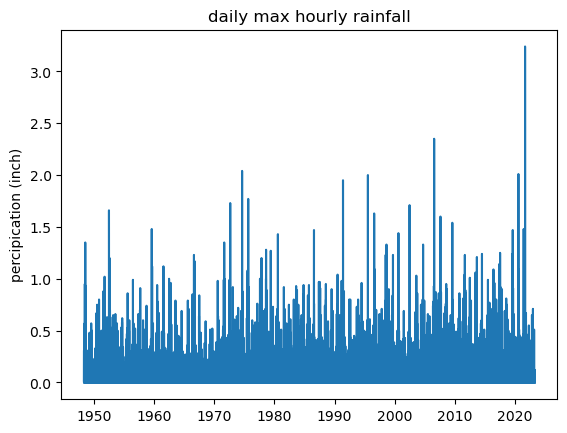

In [5]:
plt.plot(ts_hourly_max)
plt.ylabel('percipication (inch)');
plt.title('daily max hourly rainfall')

### Extreme Value Theory

Extreme Value Theory is the statistical study of extreme deviations (ie tail events). For example, stock market crashes, 100-year flood events etc.

The classical Extreme Value Theory approach is to study the statistics of *block maxima*
$$M_n = \max (X_1, \ldots, X_n)$$
where $X_i$ are iid random variables with a common distrubtion function $F$. For many applications the distribution $F$ is unknown. However, in a similar spirit as the *Central Limit Theorem*, which that in many situations the (standardized) sum of iid random variables approaches a normal distribution, the block maxima apporaches a different limit distribution.

#### Fisher–Tippett–Gnedenko theorem (limit theory for block maxima)
Suppose that there exists two sequences of real numbers $\{a_n\}$ and $\{b_n\}$ such that following limit converages to a limiting distribtion
$$\lim_{n\rightarrow \infty} P((M_n - b_n)/a_n \leq z) = G(z)$$
the CDF $G(z)$ is the so-call *Generalized Extreme Value (GEV)* distribution
$$G(z) = \exp\left( -(1+\xi z)^{-1/\xi} \right)$$ 
with $z = (x-\mu)/\sigma$.

This is an extremely powerfull result. It tells us that when we want to model extreme events via block maxima we can describe it with the GEV distribution in many cases. Full knowledge of the probablity distribution of the underlying random variables $X_i$ is not required.

#### Chosing the size of block maxima
While the theorem is strictly only valid in the limit $n \rightarrow \infty$ in reality we want to chose an $n$ 
small enough to have sufficiently data but large enough so that the GEV approximation is accurate. In practice for many applications that experience seasonality (eg when modelling extreme weather events) the size of block maxima is the number of observations per year. In other words for each year we take maximum observed value, and these are fitted to a GEV distribtion

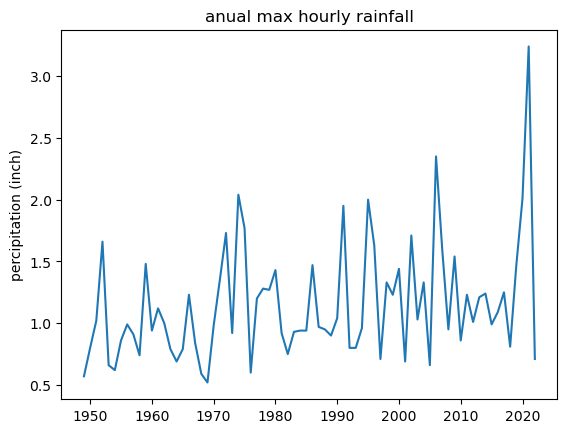

In [6]:
ts_blockmaxima = ts_hourly_max.loc['1949-01-01':'2022-12-31'].copy() #we only want full years.
ts_blockmaxima = ts_blockmaxima.to_frame("value")
ts_blockmaxima["year"] = ts_blockmaxima.index.year
ts_blockmaxima = ts_blockmaxima.groupby("year")["value"].max()
plt.plot(ts_blockmaxima)
plt.ylabel('percipitation (inch)');
plt.title('anual max hourly rainfall');

### Fitting the GEV with Maximum Likelihood Estimation (MLE)

Once we have defined the block maxima we want to fit these to the GEV distribution. We can do this by leveraging scipy implemention:

scipy.stats.genextreme.fit 

which under the hood minimizes the negative of the log likelihood using scipy.optimize.fmin

In the rest of the notebook most of the methods are abstracted in the class GEVMLE_ts for sake of brevity

In [7]:
GEV_hourly = GEVMLE_ts()
GEV_hourly.fit(ts_hourly_max)
GEV_hourly.get_params()

{'mu': 0.9219242941961374,
 'sigma': 0.29791060799659713,
 'xi': 0.16623019437413705}

The parameters $\mu$ and $\sigma$ are so-called location and scale parameters. The parameter that quantifies the *fatness* of the tails is the shape parameter $\xi$. If the underlying random variables were normally distribution $\xi=0$. In case of the hourly rainfall data $\xi>0$ meaning the underlying distribution has fatter tails compared to a normal distribution (ie positive excess kurtosis)



### Return Levels

We have now all to ingredients to answer the question what a once in a hunderd years event is.

Given a *return period* $m$ (eg once every 100 years) the *return level* $x_m$ satisfies
$$P(X>x_m) = \frac{1}{m} = p$$
In other words, we expect to observe a value of at least $x_m$ with a probality inversely proportional to the *return period* $m$. We can rewrite the probablity for the return level as

$$\exp\left( -(1+\xi z)^{-1/\xi} \right) = 1-p$$


The return level as fuction of the return period

$$ x_m = \mu - \frac{\sigma}{\xi} \left(1- \left(-\log(1-p) \right)^{-\xi}  \right) $$




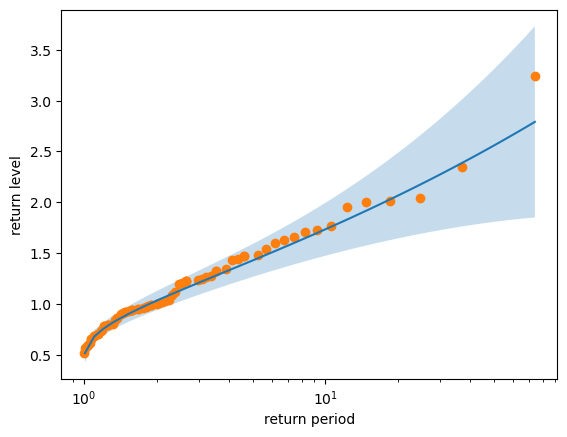

In [8]:
GEV_hourly = GEVMLE_ts()
GEV_hourly.fit(ts_hourly_max)
GEV_hourly.return_level_plot(include_ci=True,include_data=True)

Comparing with the most extreme observations

In [9]:
ts_extremes = ts_hourly_max.sort_values().tail(5).to_frame('percip_in')
ts_extremes['return period'] = ts_extremes['percip_in'].apply(GEV_hourly.return_period)
ts_extremes

,percip_in,return period
1995-07-17,2.00,17.505677
2020-07-24,2.01,17.865024
1974-08-17,2.04,18.981323
2006-07-21,2.35,34.470991
2021-09-01,3.24,147.942628


The observation of 3.24 on 2021-09-01, is about once in a 150 year event. This is extreme, but further robustness are in order to draw firmer conclusions.

### Confidence intervals

The shade area in the return level plot is the 95% confidence interval. In a different notebook we will go through the computation of these in detail. But in a nutshell it works a follows. We assume that the MLE is asumptotically normal, ie in the limit the sample size goes to infinity the parameters $\mu$, $\sigma$ and $\xi$ become normally distributed. We can use the Fisher Information to compute a covariance matrix for the standard errors of $\mu$, $\sigma$ and $\xi$. To compute a confidence interval for the return level, which is a function of these parameters, we need to "propagate the errors through" which can be done using the *delta method*.

Caveat

Obviously we need to assure our selves, that for our sample the normal approximation of the maximum likelihood is indeed valid. One way to verify this is to get confidence intervals using bootstrapping instead. 

# Is this a sign of a changing climate?

Not necessarily, however it warrants further research. Staying on te statistical track (ie not leveraging external insights from climatology), we define a time-varying model. For instance we can model that shape parameter $\xi$ to slowly vary over time. Obviously this is a model with more parameters, so we need something like AIC to determine whether this model

# What is next?

1. Model diagnostics
2. How to compute confidence intervals for the return levels
3. How to get more robust esitmate using data from nearby station
4. Time varying models (use Temperature as exogenus variable)